<center> <span style="color:indigo">Machine Learning e Inferencia Bayesiana</span> </center> 

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/2b/Centro_Universitario_del_Guadalajara_Logo.png/640px-Centro_Universitario_del_Guadalajara_Logo.png" alt="Drawing" style="width: 600px;"/>
</center>
    
<center> <span style="color:DarkBlue">  Tema 12: Clustering, Implementación con datos de e-commerce</span>  </center>
<center> <span style="color:Blue"> M. en C. Iván A. Toledano Juárez </span>  </center>

## Segmentación de clientes mediante clustering

La **segmentación de clientes** es una técnica fundamental en *marketing analytics* y *data science* que permite identificar grupos de consumidores con comportamientos similares, con el objetivo de diseñar estrategias personalizadas de retención, fidelización y venta cruzada.

En este notebook, implementaremos un análisis de clustering sobre datos reales de un e-commerce del Reino Unido, utilizando el modelo **RFM (Recency, Frequency, Monetary)** para caracterizar a los clientes según su comportamiento de compra.

Posteriormente, aplicaremos técnicas de **clustering jerárquico y k-means** para agrupar a los clientes y comparar los resultados.


In [2]:
# Importación de librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

## Importación de datos

Este set de datos contiene transacciones ocurridas entre los años 2010 y 2011 para una empresa de e-commerce localizada en Reino Unido. El origen del set de datos puede ser consultado [aqui](https://archive.ics.uci.edu/dataset/352/online+retail).

Este set de datos tiene las siguientes variables:

* InvoiceNo (categórico)
* StockCode (categórico)
* Description (categórico)
* Quantity (numérico Entero)
* InvoiceDate (Fecha)
* UnitPrice (numérico Real)
* CustomerID (categórico)
* Country (categórico)

Basado en ejercicio de [Kaggle](https://www.kaggle.com/code/hellbuoy/online-retail-k-means-hierarchical-clustering)

In [4]:
filename = "../data/ecom/OnlineRetail.csv"
data = pd.read_csv(filename,
                 sep = ",",
                 encoding = "ISO-8859-1")
data.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.shape
# Hay 541909 observaciones en el set de datos

(541909, 8)

In [7]:
data.isnull().sum()
# Hay algunos valores nulos

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Eliminar filas que contengan algún valor nulo
data_retail = data.dropna()
data_retail.shape

(406829, 8)

## El modelo RFM para segmentación de clientes

El modelo **RFM** (Recency–Frequency–Monetary) es una técnica clásica de análisis de comportamiento de clientes, ampliamente utilizada en marketing para evaluar el valor y la lealtad de los consumidores.  

Cada cliente se describe mediante tres dimensiones:

1. **Recency ($R$):** número de días desde la última compra hasta la fecha de referencia del análisis.  
   Cuanto más reciente es la compra, menor es el valor de $R$ (mejor cliente).

   \begin{equation}
   R_i = \text{Fecha actual} - \text{Última compra del cliente } i
   \end{equation}

2. **Frequency ($F$):** número total de transacciones realizadas por el cliente en el período analizado.

   \begin{equation}
   F_i = \text{Número de facturas únicas del cliente } i
   \end{equation}

3. **Monetary ($M$):** monto total gastado por el cliente.

   \begin{equation}
   M_i = \sum_{j=1}^{n_i} (\text{Cantidad}_{ij} \times \text{Precio}_{ij})
   \end{equation}

---

El principio detrás de este modelo es que los **mejores clientes** son aquellos que:
- Han comprado **recientemente** (bajo $R$),
- Compran **frecuentemente** (alto $F$),
- Gastan **grandes cantidades** (alto $M$).

Una vez obtenidos los valores RFM para cada cliente, se pueden aplicar algoritmos de clustering para identificar grupos homogéneos, tales como:
- Clientes fieles y rentables,
- Clientes inactivos,
- Clientes recientes con alto potencial, etc.

### Preparación de datos para RFM

Para construir la tabla RFM:
1. Filtramos las transacciones válidas (sin devoluciones o precios negativos).  
2. Eliminamos registros con `CustomerID` nulo.  
3. Calculamos para cada cliente:
   - Fecha de su última compra (`Recency`).
   - Número de compras (`Frequency`).
   - Total gastado (`Monetary`).

Este proceso transforma los datos transaccionales (nivel factura–producto) en un dataset agregado por cliente.

In [21]:
## Columna: Cantidad Total de transacciones

data_retail = data_retail.copy()
data_retail['Total_amount'] = data_retail['Quantity'] * data_retail['UnitPrice']

# Crear un nuevo dataframe donde se agrupa todo el total por mismo CustomerID

data_m = data_retail.groupby('CustomerID')['Total_amount'].sum()
data_m = data_m.reset_index() # se resetea el índice del data frame
data_m.head(5)

,CustomerID,Total_amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [22]:
## Columna: Número de transacciones por cliente (frecuencia)

data_f = data_retail.groupby('CustomerID')['InvoiceNo'].count() # Se cuenta el numero de veces que compra un cliente
data_f = data_f.reset_index() # se resetea el índice del data frame
data_f.head(5)

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [23]:
### Se hace un inner join de esta información en un nuevo dataframe

data_retail_2 = pd.merge(data_m, data_f,
                         on = 'CustomerID',
                         how = 'inner')
data_retail_2.head(5)

,CustomerID,Total_amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


La variable InvoiceDate no se encuentra originalmente como una variable de fecha, así que se tiene que cambiar.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [25]:
## Columna: días después de la última compra
## Se tiene que especificar qué formato tenía originalmente la información


data_retail['InvoiceDate'] = pd.to_datetime(data_retail['InvoiceDate'],
                                            format = '%m/%d/%Y %H:%M')

data_retail.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [26]:
data_retail.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype          
---  ------        --------------   -----          
 0   InvoiceNo     406829 non-null  object         
 1   StockCode     406829 non-null  object         
 2   Description   406829 non-null  object         
 3   Quantity      406829 non-null  int64          
 4   InvoiceDate   406829 non-null  datetime64[ns] 
 5   UnitPrice     406829 non-null  float64        
 6   CustomerID    406829 non-null  float64        
 7   Country       406829 non-null  object         
 8   Total_amount  406829 non-null  float64        
 9   Diff          406829 non-null  timedelta64[ns]
dtypes: datetime64[ns](1), float64(3), int64(1), object(4), timedelta64[ns](1)
memory usage: 34.1+ MB


In [27]:
## numéro de días después de la última transaccion, por cliente

# Fecha más reciente en el dataset
max_date = max(data_retail['InvoiceDate'])
print('Fecha más reciente = ', max_date)

# Diferencia entre la fecha más reciente y la fecha de las transacciones
# La mínima de estas fechas, por cliente único, nos dice los días de la última transaccion
data_retail['Diff'] = max_date - data_retail['InvoiceDate']
print(data_retail.head(5))

# Se hace un dataframe con los dias de la última transaccion, por cliente único

data_p = data_retail.groupby('CustomerID')['Diff'].min()
data_p = data_p.reset_index()
data_p.head(5)

Fecha más reciente =  2011-12-09 12:50:00
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Total_amount  \
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom         15.30   
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34   
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom         22.00   
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34   
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom         20.34   

               Diff  
0 373 days 04:24:00  
1 373 days 0

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [28]:
# Se extrae únicamente los días
data_p['Diff'] = data_p['Diff'].dt.days
data_p.head(5)

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [29]:
# Se hace un inner join con el dataframe de frecuencia y total amount

data_retail_3 = pd.merge(data_retail_2, data_p,
                         on = 'CustomerID',
                         how = 'inner')

# Renombrar columnas
data_retail_3.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
data_retail_3.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Sobre este nuevo dataframe es donde se realizará el clustering, utilizando estas tres variables sugeridas, para cada CustomerID único. A continuación, se remueven valores atípicos.

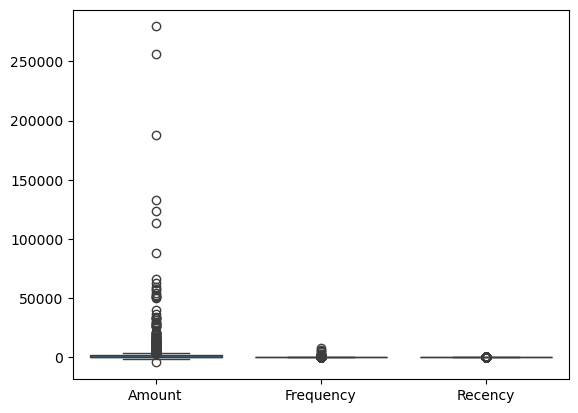

In [30]:
# Boxplot

sns.boxplot(data = data_retail_3[['Amount', 'Frequency', 'Recency']],
            orient = 'v')
plt.show()

Vemos que hay algunos valores atípicos, sobre todo en el gasto total por cliente. En este ejemplo, utilizan los cuantiles 5 (q_min) y 95 (q_max) para definir un rango IQR = q_max - q_min. Cualquier valor fuera del rango $(q_{\rm min} - 1.5\cdot{\rm IQR}, \ q_{\rm max} + 1.5\cdot{\rm IQR})$ es considerado valor atípico y no se considera en el análisis.

In [31]:
# Valores atípicos

# Variable Amount
q_min = data_retail_3.Amount.quantile(0.05)
q_max = data_retail_3.Amount.quantile(0.95)
IQR = q_max - q_min
data_retail_4 = data_retail_3[(data_retail_3.Amount >= q_min - 1.5*IQR) & \
                              (data_retail_3.Amount <= q_max + 1.5*IQR)]

# Variable Frequency
q_min = data_retail_4.Frequency.quantile(0.05)
q_max = data_retail_4.Frequency.quantile(0.95)
IQR = q_max - q_min
data_retail_4 = data_retail_4[(data_retail_4.Frequency >= q_min - 1.5*IQR) & \
                              (data_retail_4.Frequency <= q_max + 1.5*IQR)]

# Variable Recency
q_min = data_retail_4.Recency.quantile(0.05)
q_max = data_retail_4.Recency.quantile(0.95)
IQR = q_max - q_min
data_retail_4 = data_retail_4[(data_retail_4.Recency >= q_min - 1.5*IQR) & \
                              (data_retail_4.Recency <= q_max + 1.5*IQR)]

data_retail_4.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [32]:
# Shape antes y despues
print('Shape antes = ', data_retail_3.shape)
print('Shape despues = ', data_retail_4.shape)

# Se han ignorado algunos valores atípicos

Shape antes =  (4372, 4)
Shape despues =  (4293, 4)


### Normalización de las variables RFM

Las tres variables RFM están en escalas diferentes (días, conteos, montos). Para que ninguna domine el proceso de clustering, es necesario normalizarlas o estandarizarlas.

In [33]:
# Mantenemos este dataframe que ya no contiene valores atipicos
df = data_retail_4.copy()
df.head(5)

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [34]:
# Normalizacion de datos
# Tener valores entre 0 y 1 (Excepto en la variable CustomerID, esa queda igual)

attributes = ['Amount', 'Frequency', 'Recency']


df_norm = (data_retail_4[attributes] - data_retail_4[attributes].min()) / \
     (data_retail_4[attributes].max() - data_retail_4[attributes].min())

# Opcional (se vuelve a añadir la variable CustomerID)
#df = pd.DataFrame.join(data_retail_4.CustomerID.to_frame(), df,
#                       how = 'left')

df_norm.head(100)



,Amount,Frequency,Recency
0,0.238663,0.001395,0.871314
1,0.478571,0.252441,0.002681
2,0.338703,0.041841,0.198391
3,0.336494,0.100418,0.048257
4,0.257277,0.022315,0.828418
...,...,...,...
96,0.311227,0.121339,0.120643
97,0.306129,0.039052,0.024129
98,0.279513,0.069735,0.018767
99,0.278965,0.054393,0.380697


El último dataframe 'df_norm' es el que se va a utilizar en el modelo. Además de las tres variables de interés sin valores atípicos, también se considera la una normalización **max-min**.

## Clustering sobre el espacio RFM

Una vez obtenidas las variables RFM estandarizadas, aplicamos algoritmos de clustering para identificar patrones de comportamiento entre clientes.

**Opciones comunes:**
- **Clustering jerárquico:** útil para visualizar relaciones entre grupos mediante un dendrograma.  
- **K-means:** eficiente para grandes volúmenes de clientes y permite definir un número de clústeres $k$.

En ambos casos, la distancia entre clientes se calcula sobre el espacio tridimensional $(R, F, M)$.

In [39]:
# Generamos los enlaces
Z = linkage(df_norm,"ward",
            metric = 'euclidean')

In [40]:
# Funcion de Dendograma detallado

def dendrogram_detailed(*args, **kwargs):
    max_d = kwargs.pop("max_d", None) ## la maxima distancia de los argumentos
    if max_d  and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop("annotate_above", 0)
    
    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Clustering jerárquico (Detallado)')
        plt.xlabel("Índice del DataSet (o tamaño del cluster)")
        plt.ylabel("Distancia")
        for index, distance, color in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(index[1:3])
            y = distance[1] # la altura
            if y>annotate_above:
                plt.plot(x,y,'o',c=color)
                plt.annotate('%.3g'%y, (x,y), xytext=(0,-5),
                            textcoords='offset points', va='top', ha="center")
    if max_d:
        plt.axhline(y=max_d, c='k')
        
    return ddata

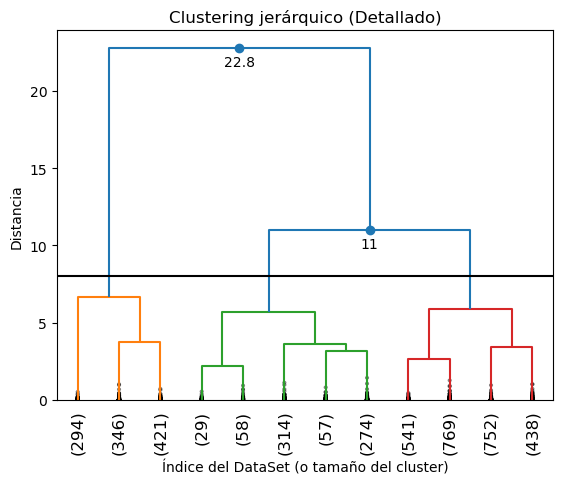

In [41]:
# Visualizamos el dendograma

dendrogram_detailed(Z,truncate_mode='lastp',p=12, leaf_rotation=90.0,leaf_font_size=12.0,
                   show_contracted=True, annotate_above=10, max_d = 8.0)
plt.show()

Vemos que posiblemente hay tres clusters. Utilizamos el método del codo para decidir.

In [47]:
# se fija en la aceleración del cambio
# nos quedamos con los últimos registros
last = Z[-10:,2] # nos quedamos solo con las distancias
last_rev = last[::-1] # la reversa del array
last_rev

array([22.76781726, 10.97092263,  6.64056922,  5.89687568,  5.71983871,
        3.77244211,  3.62697078,  3.40658433,  3.17258933,  2.65921361])

In [48]:
# tomamos indices
idx = np.arange(1,len(last) + 1)

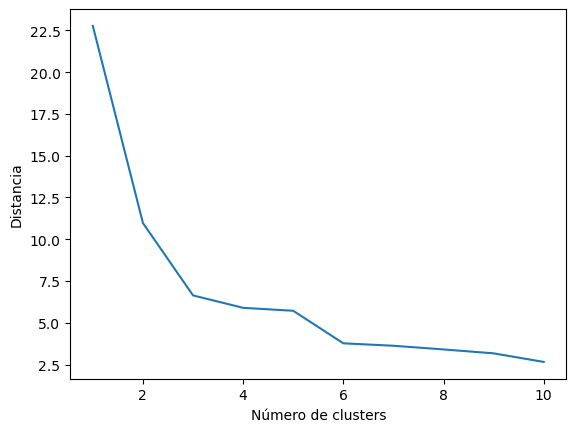

In [49]:
plt.plot(idx,last_rev)
plt.ylabel('Distancia')
plt.xlabel('Número de clusters')
plt.show()

Fuera del 'bump' en el índice 5, parece ser que una elección de 3 clusters es decente.

El método **cut_tree** de _scipy.cluster.hierarchy_ nos permite hacer este corte a tres clusters.



In [50]:
# 3 clusters

cluster_labels = cut_tree(Z, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 2, ..., 0, 2, 2])

In [51]:
# Dataframe para clustering jerarquico
# Añadimos las etiquetas de cada cluster

df_h = data_retail_4.copy()

df_h['Cluster_Labels'] = cluster_labels
df_h.head(55)

,CustomerID,Amount,Frequency,Recency,Cluster_Labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,2
3,12349.0,1757.55,73,18,2
4,12350.0,334.40,17,309,0
5,12352.0,1545.41,95,35,2
6,12353.0,89.00,4,203,0
7,12354.0,1079.40,58,231,0
8,12355.0,459.40,13,213,0
9,12356.0,2811.43,59,22,2


Ahora vemos cómo es la estadística de cada uno de los clusters identificados.

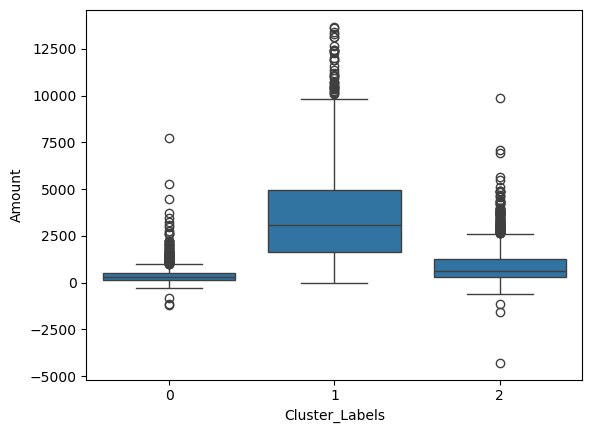

In [52]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Amount')
plt.show()

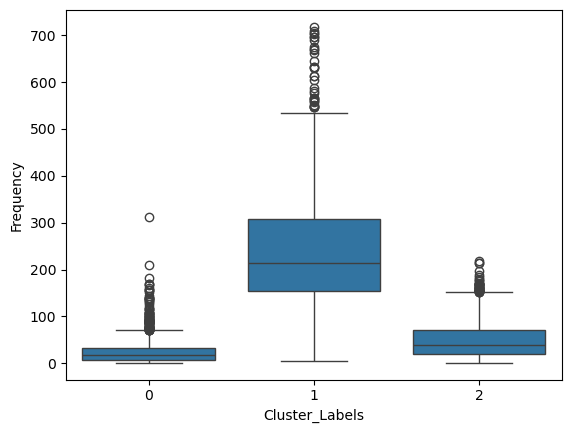

In [53]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Frequency')
plt.show()

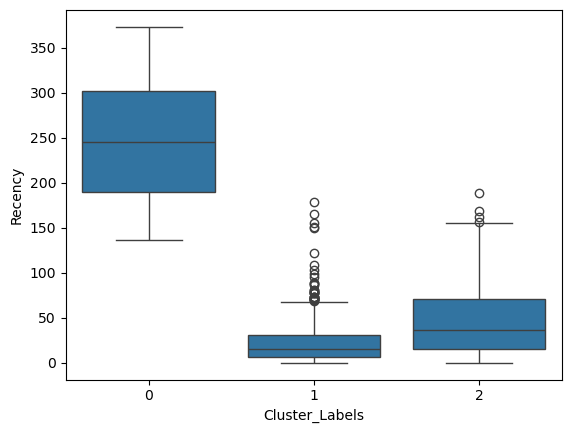

In [54]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Recency')
plt.show()

In [55]:
# Estadisticas por cluster

df_h.groupby('Cluster_Labels').mean()

,CustomerID,Amount,Frequency,Recency
Cluster_Labels,,,,
0,15348.081998,429.372536,27.089538,249.377003
1,15285.345628,3728.130943,248.430328,22.516393
2,15283.714400,907.728121,48.817600,46.496000


### Interpretación de segmentos RFM

Cada clúster puede interpretarse según los valores promedio de Recency, Frequency y Monetary:

| Tipo de cliente | Recency | Frequency | Monetary | Descripción |
|------------------|----------|------------|------------|--------------|
| **Leales** | Bajo | Alto | Alto | Compran seguido y gastan mucho. |
| **Recientes prometedores** | Bajo | Medio | Medio | Clientes nuevos con buen potencial. |
| **En riesgo** | Alto | Medio | Medio | Hace tiempo que no compran. |
| **Perdidos** | Alto | Bajo | Bajo | Clientes inactivos. |

Esta clasificación permite diseñar estrategias de marketing diferenciadas (retención, reactivación, fidelización, etc.).


# Clustering con k-medias

In [56]:
from sklearn.cluster import KMeans

In [57]:
model = KMeans(n_clusters=3,
               max_iter = 50)
model.fit(df_norm)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,50
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [58]:
# podemos ver que observaciones pertenecen a cada uno de los clusters

model.labels_

array([2, 0, 0, ..., 1, 0, 0], dtype=int32)

In [59]:
# Dataframe para clustering con k medias
df_k = data_retail_4.copy()

# Incluimos los modelos generados (hierarchy y kmeans) en el dataset normalizado
df_k['Cluster_Labels'] = model.labels_

df_k.head(5)

,CustomerID,Amount,Frequency,Recency,Cluster_Labels
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


In [60]:
# Estadistica por cluster

df_k.groupby('Cluster_Labels').mean()

,CustomerID,Amount,Frequency,Recency
Cluster_Labels,,,,
0,15285.186980,1677.547025,103.334901,29.292224
1,15336.271091,650.861227,36.025872,144.654668
2,15312.968701,370.646729,23.300469,293.771518


# Utilizando normalizacion standard

La normalización de este tipo supone que la variable tiene una distribución como una curva normal estándar (media $\mu$ = 0, desviación estándar $\sigma$ = 1) y asigna un valor acorde a esta distribución (z-valor) $z = \frac{x - \mu}{\sigma}$.

In [61]:
from sklearn.preprocessing import StandardScaler
# Reescalamiento de variables

df_norm_std = data_retail_4[['Amount', 'Frequency', 'Recency']]

# Se utiliza el método StandardScaler de Scikit learn para generar esta distribución
scaler = StandardScaler()

# Se aplica la transformación a los datos según esta distribución normal estándar
df_norm_std = scaler.fit_transform(df_norm_std)
df_norm_std.shape


(4293, 3)

In [62]:
df_norm_std = pd.DataFrame(df_norm_std)
df_norm_std.columns = ['Amount', 'Frequency', 'Recency']
df_norm_std.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


## Clustering jerárquico (standard normalization)

In [63]:
# Generamos los enlaces (se utiliza metodo de enlace average)
Z = linkage(df_norm_std,"average",
            metric = 'euclidean')

In [64]:
# Funcion de Dendograma detallado

def dendrogram_detailed(*args, **kwargs):
    max_d = kwargs.pop("max_d", None) ## la maxima distancia de los argumentos
    if max_d  and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop("annotate_above", 0)
    
    ddata = dendrogram(*args, **kwargs)
    
    if not kwargs.get('no_plot', False):
        plt.title('Clustering jerárquico (Detallado)')
        plt.xlabel("Índice del DataSet (o tamaño del cluster)")
        plt.ylabel("Distancia")
        for index, distance, color in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(index[1:3])
            y = distance[1] # la altura
            if y>annotate_above:
                plt.plot(x,y,'o',c=color)
                plt.annotate('%.3g'%y, (x,y), xytext=(0,-5),
                            textcoords='offset points', va='top', ha="center")
    if max_d:
        plt.axhline(y=max_d, c='k')
        
    return ddata

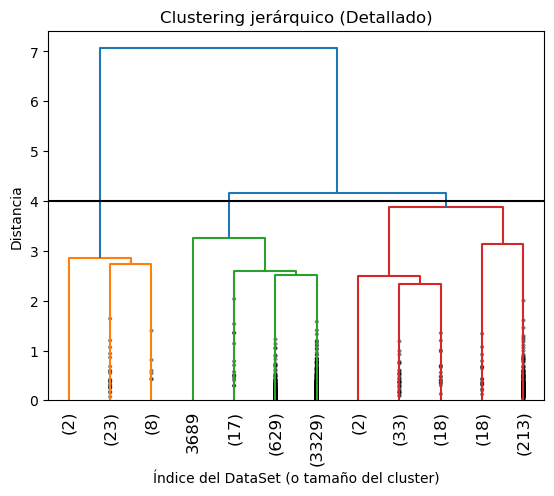

In [65]:
# Visualizamos el dendograma

dendrogram_detailed(Z,truncate_mode='lastp',p=12, leaf_rotation=90.0,leaf_font_size=12.0,
                   show_contracted=True, annotate_above=10, max_d = 4.0)
plt.show()

Vemos que posiblemente hay tres clusters. Utilizamos el método del codo para decidir.

In [66]:
# se fija en la aceleración del cambio
# nos quedamos con los últimos registros
last = Z[-10:,2] # nos quedamos solo con las distancias
last_rev = last[::-1] # la reversa del array
last_rev

array([7.06184453, 4.15219635, 3.87538552, 3.252552  , 3.13458693,
       2.86341657, 2.73242476, 2.59037261, 2.50932753, 2.49375128])

In [67]:
# tomamos indices
idx = np.arange(1,len(last) + 1)

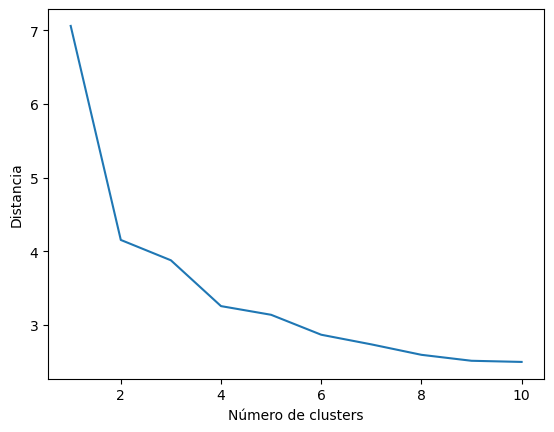

In [68]:
plt.plot(idx,last_rev)
plt.ylabel('Distancia')
plt.xlabel('Número de clusters')
plt.show()

In [69]:
# 3 clusters

cluster_labels = cut_tree(Z, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
# Dataframe para clustering jerarquico
# Añadimos las etiquetas de cada cluster

df_h = data_retail_4.copy()

df_h['Cluster_Labels'] = cluster_labels
df_h.head(5)

,CustomerID,Amount,Frequency,Recency,Cluster_Labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,0


Ahora vemos cómo es la estadística de cada uno de los clusters identificados.

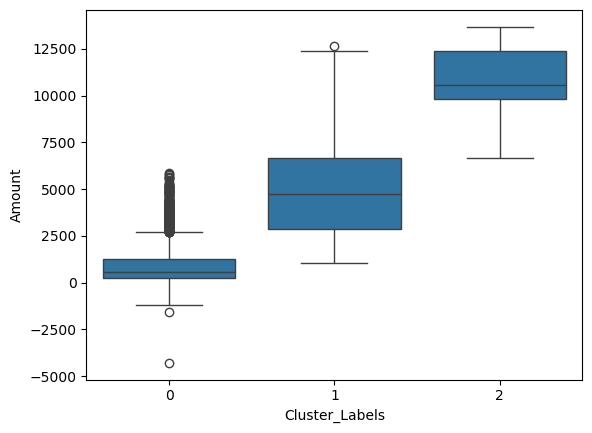

In [71]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Amount')
plt.show()

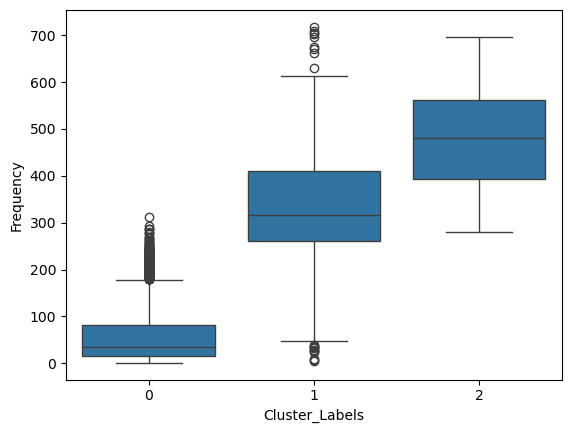

In [72]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Frequency')
plt.show()

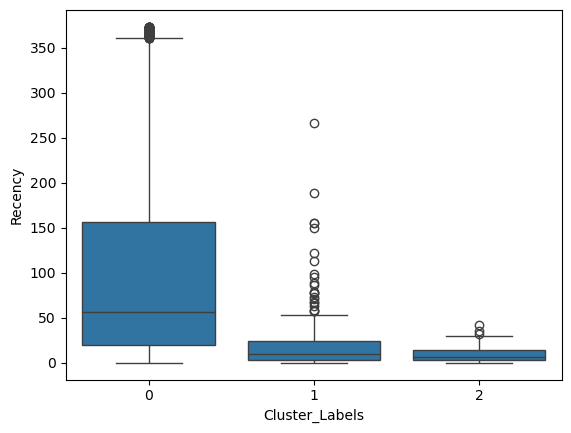

In [73]:
sns.boxplot(data = df_h,
            x = 'Cluster_Labels',
            y = 'Recency')
plt.show()

In [74]:
# Estadisticas por cluster

df_h.groupby('Cluster_Labels').mean()

,CustomerID,Amount,Frequency,Recency
Cluster_Labels,,,,
0,15306.365191,924.448987,56.577968,98.394115
1,15244.116197,5013.334261,323.197183,20.334507
2,15001.121212,10741.827576,481.666667,9.727273


## Clustering k-medias (standard normalization)

In [76]:
from sklearn.cluster import KMeans

In [78]:
model = KMeans(n_clusters=3,
               max_iter = 50,
               init = 'k-means++',
               tol = 0.001,
               random_state = None,
               algorithm = 'lloyd')
model.fit(df_norm_std)

,n_clusters,3
,init,'k-means++'
,n_init,'auto'
,max_iter,50
,tol,0.001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [79]:
# podemos ver que observaciones pertenecen a cada uno de los clusters

model.labels_

array([0, 2, 1, ..., 0, 1, 1], dtype=int32)

In [80]:
# Dataframe para clustering con k medias
df_k = df.copy()

# Incluimos los modelos generados (hierarchy y kmeans) en el dataset normalizado
df_k['Cluster_Labels'] = model.labels_

df_k.head(5)

,CustomerID,Amount,Frequency,Recency,Cluster_Labels
0,12346.0,0.00,2,325,0
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,0


In [81]:
# Estadistica por cluster

df_k.groupby('Cluster_Labels').mean()

,CustomerID,Amount,Frequency,Recency
Cluster_Labels,,,,
0,15372.805061,388.119092,25.413308,248.376757
1,15308.548955,951.699411,59.538687,44.540887
2,15096.749499,4898.735571,286.891784,21.703407


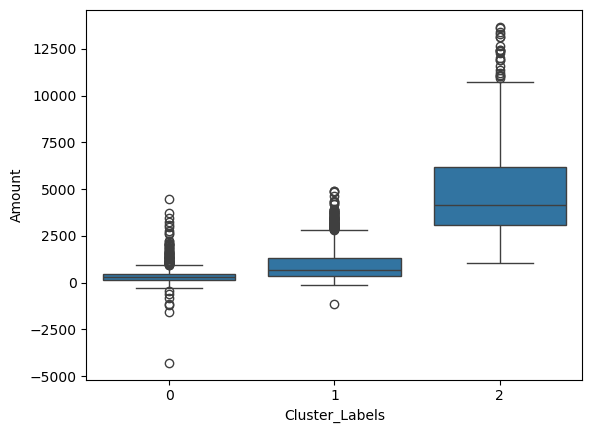

In [82]:
sns.boxplot(data = df_k,
            x = 'Cluster_Labels',
            y = 'Amount')
plt.show()

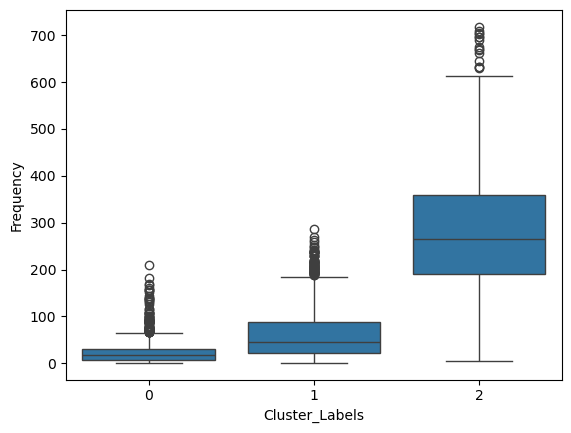

In [83]:
sns.boxplot(data = df_k,
            x = 'Cluster_Labels',
            y = 'Frequency')
plt.show()

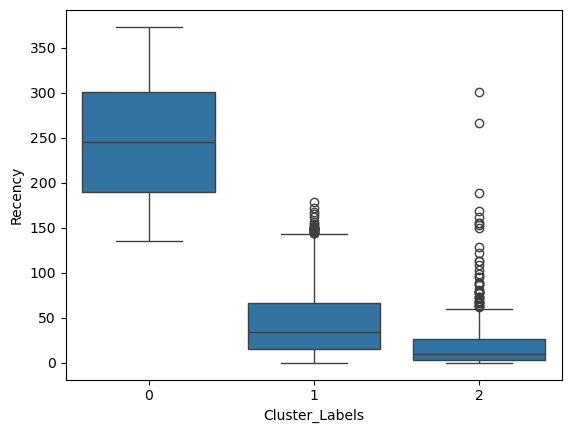

In [84]:
sns.boxplot(data = df_k,
            x = 'Cluster_Labels',
            y = 'Recency')
plt.show()

In [85]:
from sklearn.metrics import silhouette_score

# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(df_norm_std)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_norm_std, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4777820100216849
For n_clusters=5, the silhouette score is 0.46399070900769845
For n_clusters=6, the silhouette score is 0.4169515238218781
For n_clusters=7, the silhouette score is 0.41483597231479047
For n_clusters=8, the silhouette score is 0.3311862982861172


## Conclusiones

El modelo RFM proporciona una base sólida para la segmentación de clientes, al capturar tres dimensiones fundamentales del comportamiento de compra.

El uso de técnicas de **clustering** permite descubrir patrones ocultos en el comportamiento de los consumidores y ofrecer estrategias más personalizadas.  
En contextos reales de comercio electrónico, este análisis puede combinarse con información demográfica o de interacción digital para construir una visión completa del cliente.
